In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax
import jax.random as jr
import jax.numpy as jnp
import pylab as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time


# local imports
import sys
sys.path.append('../')

from util.ellipse import plot_ellipse, create_ellipse

from dais.DAIS import DAIS as DAIS
from dais.AMIS import AMIS
from dais.OAIS import OAIS

from dais.proba.density import LogDensityGeneral
from dais.proba.student import Student
from dais.variational.double_stochastic import DoubleStochastic

from data_regression.regression_logdensity import make_regression_logdensity

In [2]:
# initialize random number generator
key = jr.key(0)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
data_list = ["spam", "krkp", "ionosphere", "mushroom"]

In [4]:
# create a dictionary to store the log density objects
log_density_dict = {}
for model_name in data_list:
    _log_density, dim = make_regression_logdensity(model_name)

    # create the log density object
    log_density_dict[model_name] = {"logdensity": LogDensityGeneral(logdensity=_log_density, dim=dim),
                                    "dim": dim}

### Find MAP and curvature at MAP

In [5]:
# create a dictionary to store the Laplace approximation
# {model_name: {"x_MAP": x_MAP, "cov": cov, "loss_history": loss_history}}
laplace_dict = {}
for model_name in data_list:    
    print("Model: ", model_name)
    dim = log_density_dict[model_name]["dim"]
    # do a Laplace approximation
    x_MAP = np.zeros(dim)

    # find the MAP with L-BFGS and monitor the convergence with a callback
    loss_history = []
    def callback(x):
        loss = -log_density_dict[model_name]["logdensity"](x)
        loss_history.append(loss)
        #print(loss)

    @jax.jit
    def loss(x):
        return -log_density_dict[model_name]["logdensity"](x)
    loss_grad = jax.jit(jax.grad(loss))
    res = minimize(
                fun=loss,
                x0=x_MAP,
                jac=loss_grad, 
                tol=1e-10,
                callback=callback)
    x_MAP = res.x
    hessian = jax.hessian(loss)(x_MAP)
    cov = np.linalg.inv(hessian)
    
    laplace_dict[model_name] = {"x_MAP": x_MAP, "cov": cov, "loss_history": loss_history}

Model:  spam
Model:  krkp
Model:  ionosphere
Model:  mushroom


Text(0.5, 0.98, 'Training curves for Laplace approximation')

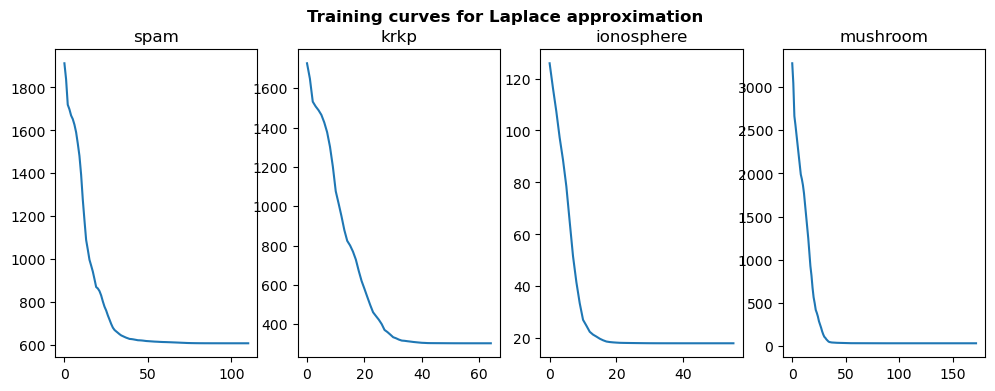

In [6]:
# plot the training curves for each model
fig, ax = plt.subplots(1, len(data_list), figsize=(len(data_list)*3, 3+1))
for i, model_name in enumerate(data_list):
    ax[i].plot(laplace_dict[model_name]["loss_history"])
    ax[i].set_title(model_name)

# global title: Training curves for Laplace approximation
# use bold font
fig.suptitle("Training curves for Laplace approximation", fontweight='bold')

Text(0.5, 0.98, 'Laplace correlation matrices')

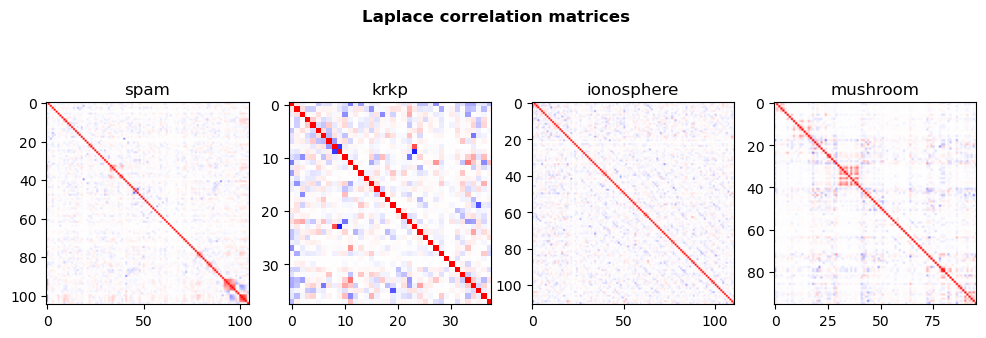

In [7]:
# plot all the Laplace correlation matrices with imshow
fig, ax = plt.subplots(1, len(data_list), figsize=(len(data_list)*3, 3+1))
for i, model_name in enumerate(data_list):
    cov = laplace_dict[model_name]["cov"]
    corr = cov / np.sqrt(np.outer(np.diag(cov), np.diag(cov)))
    ax[i].imshow(corr, cmap="bwr", vmin=-1, vmax=1)
    ax[i].set_title(model_name)

# global title: Laplace correlation matrices
# use bold font
fig.suptitle("Laplace correlation matrices", fontweight='bold')


## Doubly Adaptive Importance Sampling (DAIS)

In [8]:
n_samples = 10**5


def run_dais(Stein_update):
    dais_dict = {}
    
    for model_name in data_list:
        time_start = time.time()
        print("Model: ", model_name)
        logdensity = log_density_dict[model_name]["logdensity"]
        mu_init = laplace_dict[model_name]["x_MAP"]
        cov_init = laplace_dict[model_name]["cov"]
        dais = DAIS(logtarget=logdensity)
        dais_output = dais.run(key=key,
                            n_samples=n_samples,
                            n_iter=1000,
                            mu_init=mu_init,
                            cov_init=cov_init,
                            ess_threshold=10.**3/ n_samples,
                            c_robust=0.5,
                            verbose=True,
                            adaptive_stopping=True,
                            patience = 5,
                            Stein_update = Stein_update,
                            )
        dais_dict[model_name] = dais_output
        time_taken = time.time() - time_start
        print(f"Time taken: {time_taken:.2f} seconds")
    
    return dais_dict


# Run DAIS.
dais_dict = run_dais(Stein_update = True)

Model:  spam
[00001/1000] 	 eps: 0.61 	 ELBO: -603.57 	 ESS: 0.000
[00002/1000] 	 eps: 0.78 	 ELBO: -600.74 	 ESS: 0.001
[00003/1000] 	 eps: 0.86 	 ELBO: -599.30 	 ESS: 0.001
[00004/1000] 	 eps: 1.00 	 ELBO: -598.75 	 ESS: 0.047
[00005/1000] 	 eps: 1.00 	 ELBO: -598.54 	 ESS: 0.136
[00006/1000] 	 eps: 1.00 	 ELBO: -598.49 	 ESS: 0.100
min_elbo_last_iterations: -600.74 	 max_elbo - 2*fluctuation: -600.55
[00007/1000] 	 eps: 1.00 	 ELBO: -598.50 	 ESS: 0.082
min_elbo_last_iterations: -599.30 	 max_elbo - 2*fluctuation: -599.55
Time taken: 48.44 seconds
Model:  krkp
[00001/1000] 	 eps: 1.00 	 ELBO: -299.44 	 ESS: 0.064
[00002/1000] 	 eps: 1.00 	 ELBO: -298.61 	 ESS: 0.266
[00003/1000] 	 eps: 1.00 	 ELBO: -298.41 	 ESS: 0.335
[00004/1000] 	 eps: 1.00 	 ELBO: -298.36 	 ESS: 0.589
[00005/1000] 	 eps: 1.00 	 ELBO: -298.34 	 ESS: 0.637
[00006/1000] 	 eps: 1.00 	 ELBO: -298.33 	 ESS: 0.646
min_elbo_last_iterations: -298.61 	 max_elbo - 2*fluctuation: -298.96
Time taken: 20.36 seconds
Model:  io

In [9]:
# Run DAIS without variance reduction via Stein's lemma.
dais_dict_no_Stein = run_dais(Stein_update = False)

Model:  spam
[00001/1000] 	 eps: 0.61 	 ELBO: -603.57 	 ESS: 0.000
[00002/1000] 	 eps: 0.79 	 ELBO: -601.40 	 ESS: 0.001
[00003/1000] 	 eps: 0.87 	 ELBO: -600.28 	 ESS: 0.002
[00004/1000] 	 eps: 0.91 	 ELBO: -599.72 	 ESS: 0.004
[00005/1000] 	 eps: 1.00 	 ELBO: -599.58 	 ESS: 0.016
[00006/1000] 	 eps: 1.00 	 ELBO: -599.23 	 ESS: 0.050
min_elbo_last_iterations: -601.40 	 max_elbo - 2*fluctuation: -600.70
[00007/1000] 	 eps: 1.00 	 ELBO: -598.88 	 ESS: 0.033
min_elbo_last_iterations: -600.28 	 max_elbo - 2*fluctuation: -599.54
[00008/1000] 	 eps: 1.00 	 ELBO: -598.87 	 ESS: 0.044
min_elbo_last_iterations: -599.72 	 max_elbo - 2*fluctuation: -599.27
[00009/1000] 	 eps: 1.00 	 ELBO: -598.79 	 ESS: 0.118
min_elbo_last_iterations: -599.58 	 max_elbo - 2*fluctuation: -599.07
[00010/1000] 	 eps: 1.00 	 ELBO: -598.61 	 ESS: 0.132
min_elbo_last_iterations: -599.23 	 max_elbo - 2*fluctuation: -598.89
[00011/1000] 	 eps: 1.00 	 ELBO: -598.59 	 ESS: 0.111
min_elbo_last_iterations: -598.88 	 max_elb

<>:6: SyntaxWarning: invalid escape sequence '\g'
<>:6: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_104558/2321602485.py:6: SyntaxWarning: invalid escape sequence '\g'
  plt.title(f"{model_name}: $\gamma_t$")


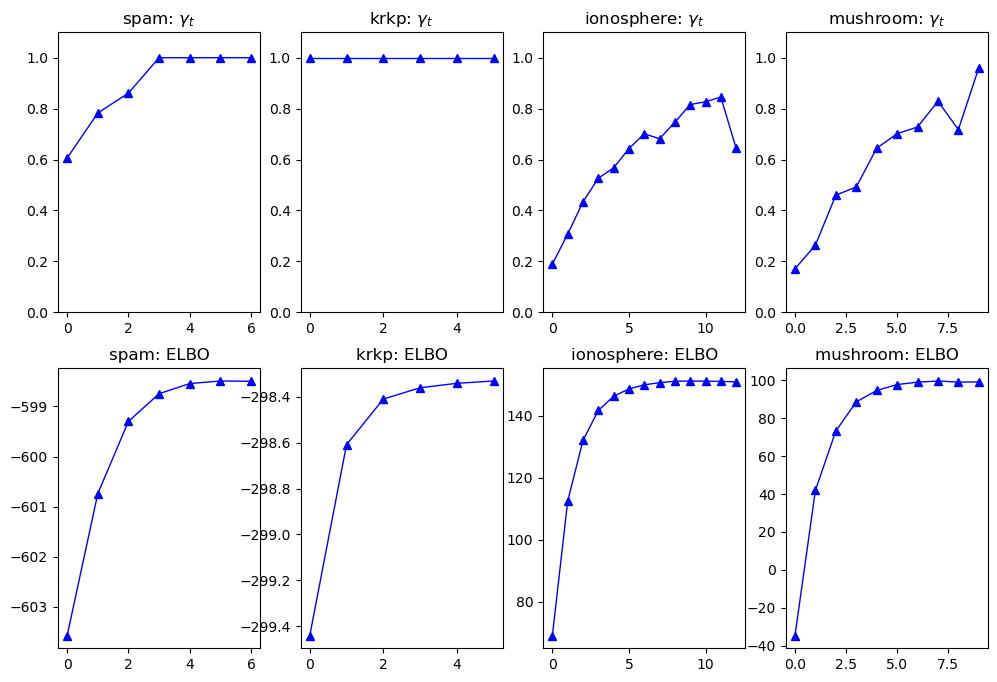

In [17]:
plt.figure(figsize=(len(data_list)*3, 2*3+2))
for i,model_name in enumerate(data_list):
    dais_output = dais_dict[model_name]
    plt.subplot(2, len(data_list), i+1)
    plt.plot(dais_output["eps_traj"], "-^", lw=1, color='blue', label=r"$\gamma_t$")
    plt.title(f"{model_name}: $\gamma_t$")
    plt.ylim(0,1.1)
    plt.subplot(2, len(data_list), len(data_list)+i+1)
    plt.plot(dais_output["elbo_traj"], "-^", lw=1, color='blue', label="ELBO")
    plt.title(f"{model_name}: ELBO")


## Variational Inference (DSVI)

In [11]:
# Run Double Stochastic Variational Inference: Full Rank approximation of the covariance
dsvi_dict = {}
n_samples = 500
n_iter = 1_000
LR = 1e-2
for model_name in data_list:
    print("Model: ", model_name)
    logdensity = log_density_dict[model_name]["logdensity"]
    mu_init = laplace_dict[model_name]["x_MAP"]
    cov_init = laplace_dict[model_name]["cov"]
    DSVI = DoubleStochastic(logtarget=logdensity)
    DSVI_output = DSVI.run(
                        key=key,
                        n_samples = n_samples,
                        mu_init=mu_init,
                        cov_init=cov_init,
                        n_iter=n_iter,
                        adam_lr=LR,
                        approx_type = "full",
                        verbose=False)
    dsvi_dict[model_name] = DSVI_output

Model:  spam
Model:  krkp
Model:  ionosphere
Model:  mushroom


In [12]:
# Run Double Stochastic Variational Inference: Diagonal approximation of the covariance
dsvi_diag_dict = {}
n_samples = 1000
n_iter = 1_000
LR = 1e-2
for model_name in data_list:
    print("Model: ", model_name)
    logdensity = log_density_dict[model_name]["logdensity"]
    mu_init = laplace_dict[model_name]["x_MAP"]
    cov_init = laplace_dict[model_name]["cov"]
    DSVI = DoubleStochastic(logtarget=logdensity)
    DSVI_output = DSVI.run(
                        key=key,
                        n_samples = n_samples,
                        mu_init=mu_init,
                        log_std_init=np.log(np.sqrt(np.diag(cov_init))),
                        n_iter=n_iter,
                        adam_lr=LR,
                        approx_type = "diag",
                        verbose=False)
    dsvi_diag_dict[model_name] = DSVI_output

Model:  spam
Model:  krkp
Model:  ionosphere
Model:  mushroom


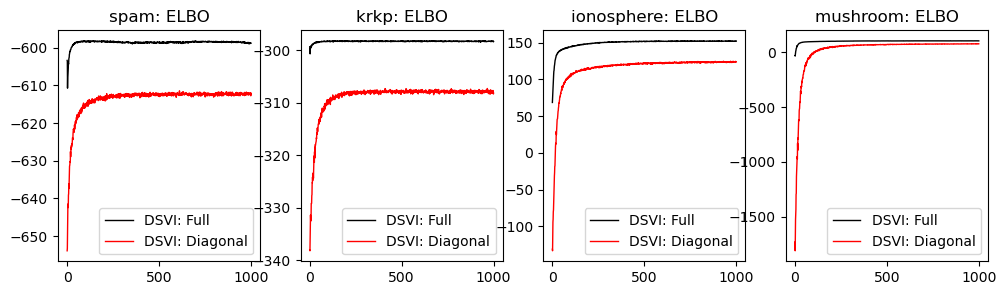

In [13]:
plt.figure(figsize=(len(data_list)*3, 1*3))
for i,model_name in enumerate(data_list):
    plt.subplot(1, len(data_list), i+1)
    dsvi_output = dsvi_dict[model_name]
    plt.plot( np.array(dsvi_output["elbo_trace"]), label="DSVI: Full", lw=1, color='black')
    dsvi_output = dsvi_diag_dict[model_name]
    plt.plot( np.array(dsvi_output["elbo_trace"]), label="DSVI: Diagonal", lw=1, color='red')
    plt.title(f"{model_name}: ELBO")
    plt.legend(loc="lower right")

## Run AMIS

In [14]:
model_name = "mushroom"
amis_dict = {}

for model_name in data_list:
    print("Model: ", model_name)
    logdensity = log_density_dict[model_name]["logdensity"]
    mu_init = laplace_dict[model_name]["x_MAP"]
    cov_init = laplace_dict[model_name]["cov"]
    amis = AMIS(logtarget=logdensity)
    key, key_ = jr.split(key)
    amis_output = amis.run(
                    key=key_,
                    n_samples=10**5,
                    n_iter=20,
                    mu_init=mu_init,
                    cov_init=cov_init,
                    family="student",
                    verbose=True)
    amis_dict[model_name] = amis_output

Model:  spam
Iteration 1/20
Iteration 2/20
Iteration 3/20
Iteration 4/20
Iteration 5/20
Iteration 6/20
Iteration 7/20
Iteration 8/20
Iteration 9/20
Iteration 10/20
Iteration 11/20
Iteration 12/20
Iteration 13/20
Iteration 14/20
Iteration 15/20
Iteration 16/20
Iteration 17/20
Iteration 18/20
Iteration 19/20
Iteration 20/20
Model:  krkp
Iteration 1/20
Iteration 2/20
Iteration 3/20
Iteration 4/20
Iteration 5/20
Iteration 6/20
Iteration 7/20
Iteration 8/20
Iteration 9/20
Iteration 10/20
Iteration 11/20
Iteration 12/20
Iteration 13/20
Iteration 14/20
Iteration 15/20
Iteration 16/20
Iteration 17/20
Iteration 18/20
Iteration 19/20
Iteration 20/20
Model:  ionosphere
Iteration 1/20
Iteration 2/20
Iteration 3/20
Iteration 4/20
Iteration 5/20
Iteration 6/20
Iteration 7/20
Iteration 8/20
Iteration 9/20
Iteration 10/20
Iteration 11/20
Iteration 12/20
Iteration 13/20
Iteration 14/20
Iteration 15/20
Iteration 16/20
Iteration 17/20
Iteration 18/20
Iteration 19/20
Iteration 20/20
Model:  mushroom
Itera

### Optimized Adaptive Importance Sampling (OAIS)

In [15]:
oais_diag_dict = {}
n_samples = 1000
n_iter = 100
LR = 1e-1
#for model_name in data_list:
model_name = "spam"
print("Model: ", model_name)
logdensity = log_density_dict[model_name]["logdensity"]
mu_init = laplace_dict[model_name]["x_MAP"]
cov_init = laplace_dict[model_name]["cov"]
oais_diag = OAIS(logtarget=logdensity)

oais_diag_output = oais_diag.run(
                    key=key,
                    n_samples = n_samples,
                    n_iter=n_iter,
                    mu_init=mu_init,
                    log_std_init=np.log(np.sqrt(np.diag(cov_init))),
                    adam_lr=LR,
                    approx_type = "diag",
                    use_jit=True,
                    verbose=True)
oais_diag_dict[model_name] = oais_diag_output

Model:  spam
Initial Objective: 0.00000
iter 0, Objective: 0.00000
iter 1, Objective: 0.00000
iter 2, Objective: 0.00000
iter 3, Objective: 0.00000
iter 4, Objective: 0.00000
iter 5, Objective: 0.00000
iter 6, Objective: 0.00000
iter 7, Objective: 0.00000
iter 8, Objective: 0.00000
iter 9, Objective: 0.00000
iter 10, Objective: 0.00000
iter 11, Objective: 0.00000
iter 12, Objective: 0.00000
iter 13, Objective: 0.00000
iter 14, Objective: 0.00000
iter 15, Objective: 0.00000
iter 16, Objective: 0.00000
iter 17, Objective: 0.00000
iter 18, Objective: 0.00000
iter 19, Objective: 0.00000
iter 20, Objective: 0.00000
iter 21, Objective: 0.00000
iter 22, Objective: 0.00000
iter 23, Objective: 0.00000
iter 24, Objective: 0.00000
iter 25, Objective: 0.00000
iter 26, Objective: 0.00000
iter 27, Objective: 0.00000
iter 28, Objective: 0.00000
iter 29, Objective: 0.00000
iter 30, Objective: 0.00000
iter 31, Objective: 0.00000
iter 32, Objective: 0.00000
iter 33, Objective: 0.00000
iter 34, Objective

## Plot results

<Figure size 1200x600 with 0 Axes>

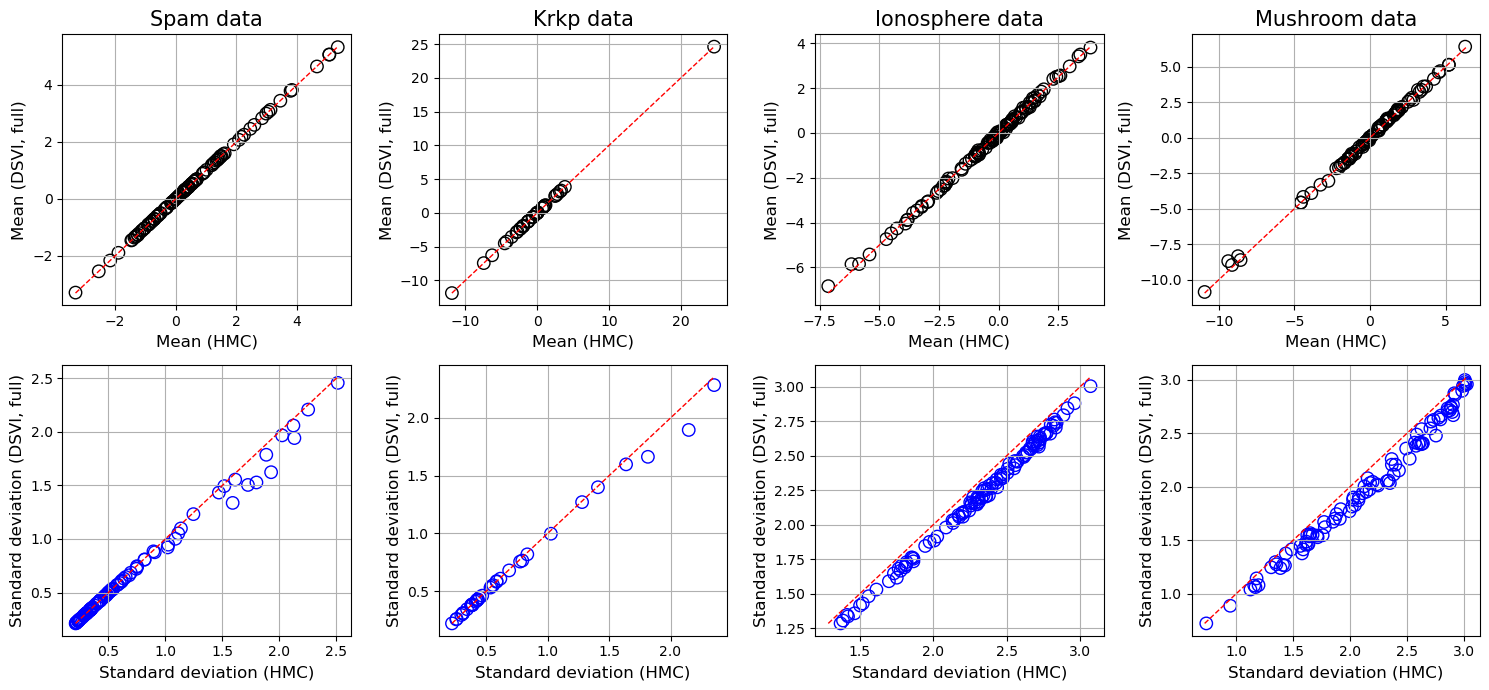

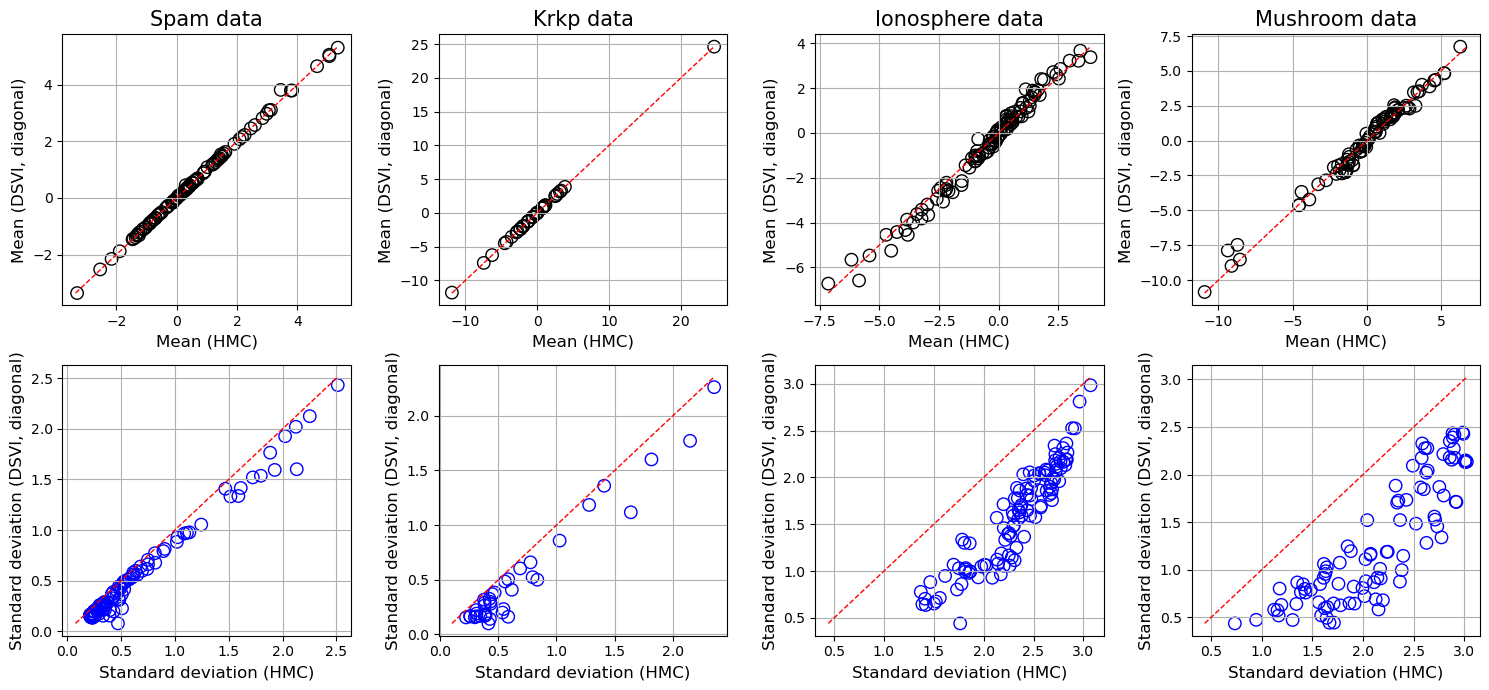

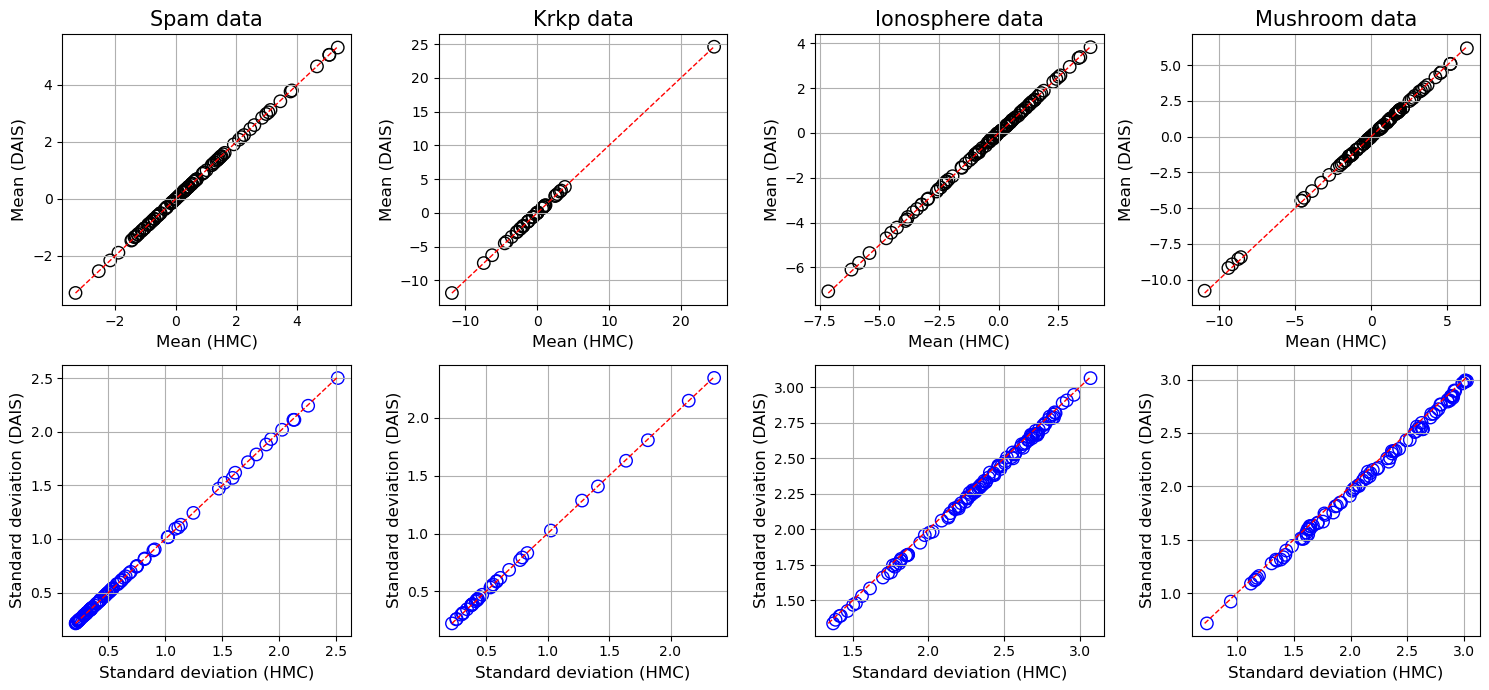

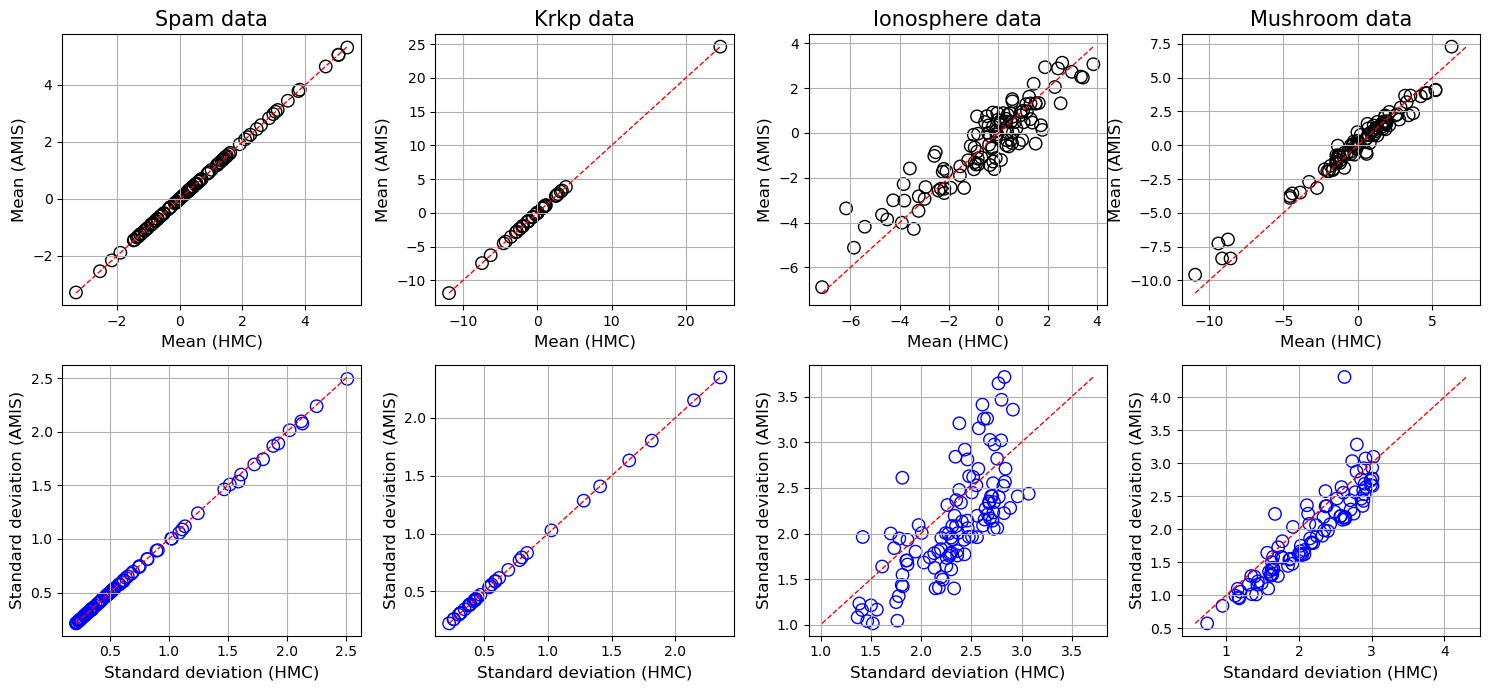

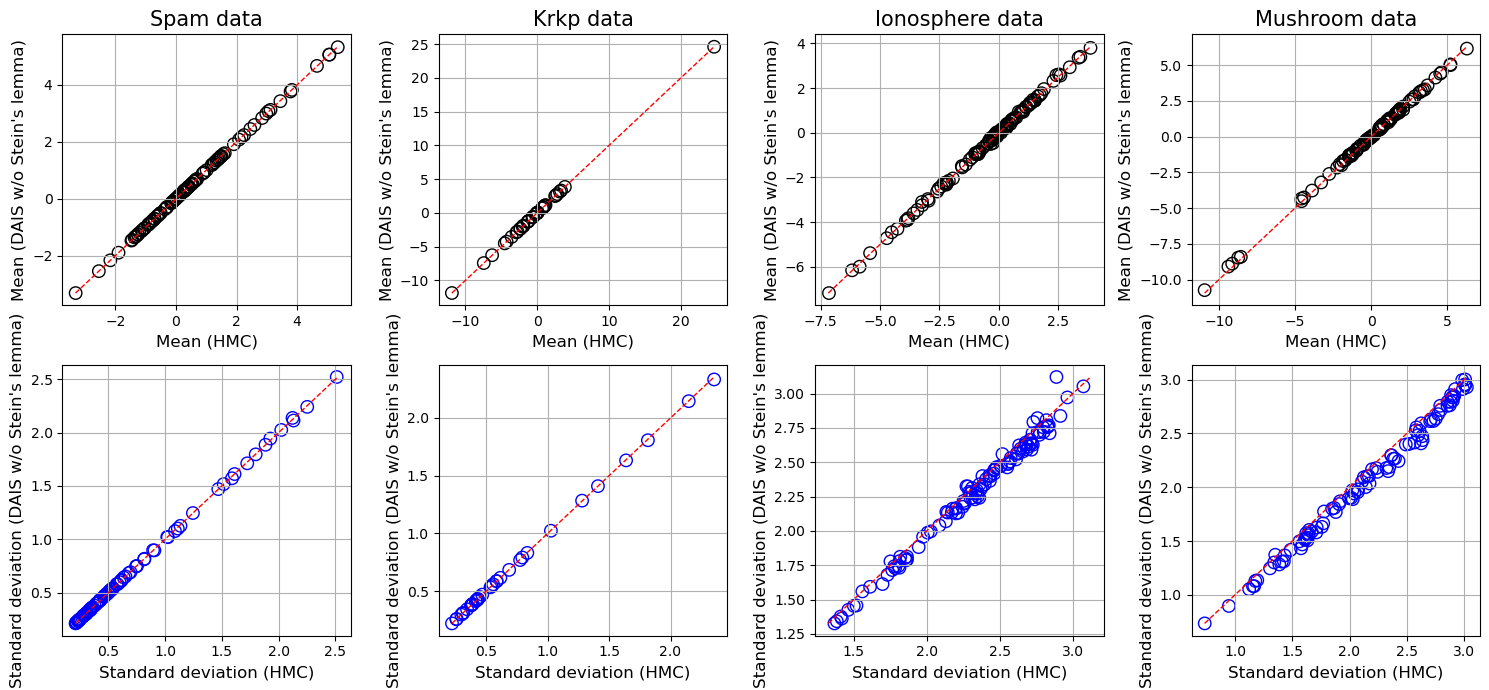

In [18]:
# plot verious methods vs HMC
plt.figure(figsize=(len(data_list)*3, 2*2+2))
folder_name = "../data_regression/mcmc_outputs"

statistics_data = {}
statistics_data["blackjax"] = {}
statistics_data["dsvi_full"] = {}
statistics_data["dsvi_diag"] = {}
statistics_data["dais"] = {}
statistics_data["amis"] = {}
statistics_data["dais_no_Stein"] = {}

statistics_data["dsvi_full"]["method"] = "DSVI, full"
statistics_data["dsvi_diag"]["method"] = "DSVI, diagonal"
statistics_data["dais"]["method"] = "DAIS"
statistics_data["amis"]["method"] = "AMIS"
statistics_data["dais_no_Stein"]["method"] = "DAIS w/o Stein's lemma"

for i, model_name in enumerate(data_list):
    # BLACKJAX
    blackjax_data = np.load(folder_name + "/" + model_name + "_MCMC.npz")
    mu_blackjax = blackjax_data["mu_mcmc"]
    variances_blackjax = np.diag(blackjax_data["Sigma_mcmc"])
    sigma_blackjax = np.sqrt(variances_blackjax)
    
    # DSVI FULL
    dsvi_output = dsvi_dict[model_name]
    cov_chol_DSVI = dsvi_output['params']["cov_chol"]
    cov_DSVI_FULL = np.dot(cov_chol_DSVI, cov_chol_DSVI.T)
    mu_DSVI_FULL = dsvi_output['params']["mu"]
    sigma_DSVI_FULL = np.sqrt(np.diag(cov_DSVI_FULL))
    
    # DSVI DIAG
    mu_DSVI_DIAG = dsvi_diag_dict[model_name]["params"]["mu"]
    log_std_diag = dsvi_diag_dict[model_name]["params"]["log_std"]
    sigma_DSVI_DIAG = std_diag = np.exp(log_std_diag)
    
    # DAIS
    mu_DAIS = dais_dict[model_name]["mu"]
    cov_DAIS = dais_dict[model_name]["cov"]
    sigma_DAIS = np.sqrt(np.diag(cov_DAIS))
    
    # AMIS
    amis_output = amis_dict[model_name]
    mu_AMIS = amis_output["mu"]
    cov_AMIS = amis_output["cov"]
    sigma_AMIS = np.sqrt(np.diag(cov_AMIS))

    # DAIS without Stein's lemma
    mu_DAIS_no_Stein = dais_dict_no_Stein[model_name]["mu"]
    cov_DAIS_no_Stein = dais_dict_no_Stein[model_name]["cov"]
    sigma_DAIS_no_Stein = np.sqrt(np.diag(cov_DAIS_no_Stein))
    
    statistics_data["blackjax"][model_name] = {"mu": mu_blackjax, "sigma": sigma_blackjax}
    statistics_data["dsvi_full"][model_name] = {"mu": mu_DSVI_FULL, "sigma": sigma_DSVI_FULL}
    statistics_data["dsvi_diag"][model_name] = {"mu": mu_DSVI_DIAG, "sigma": sigma_DSVI_DIAG}
    statistics_data["dais"][model_name] = {"mu": mu_DAIS, "sigma": sigma_DAIS}
    statistics_data["amis"][model_name] = {"mu": mu_AMIS, "sigma": sigma_AMIS}
    statistics_data["dais_no_Stein"][model_name] = {"mu": mu_DAIS_no_Stein, "sigma": sigma_DAIS_no_Stein}

method = ["dsvi_full", "dsvi_diag", "dais", "amis", "dais_no_Stein"]
fontsize = 12

for method_name in method:
    plt.figure(figsize=(len(data_list)*3+3, 2*3+1))
    for i, model_name in enumerate(data_list):
        mu_blackjax = statistics_data["blackjax"][model_name]["mu"]
        sigma_blackjax = statistics_data["blackjax"][model_name]["sigma"]
        mu = statistics_data[method_name][model_name]["mu"]
        sigma = statistics_data[method_name][model_name]["sigma"]
        
        plt.subplot(2, len(data_list), i+1)
        plt.scatter(mu_blackjax, mu,
                    facecolors='none', edgecolors='k', s=80, lw=1,
                    label=method_name)
        plt.xlabel("Mean (HMC)", fontsize=fontsize)
        plt.ylabel(f"Mean ({statistics_data[method_name]["method"]})", fontsize=fontsize)
        # add the diagonal line
        x_min_blackjax, x_max_blackjax = np.min(mu_blackjax), np.max(mu_blackjax)
        x_min_method, x_max_method = np.min(mu), np.max(mu)
        x_min, x_max = min(x_min_blackjax, x_min_method), max(x_max_blackjax, x_max_method)
        plt.plot([x_min, x_max], [x_min, x_max], 'r--', lw=1)
        plt.grid()
        plt.title(f"{model_name.capitalize()} data", fontsize=15)
        
        plt.subplot(2, len(data_list), len(data_list) + i+1)
        plt.scatter(sigma_blackjax, sigma,
                    facecolors='none', edgecolors='blue', s=80, lw=1,
                    label=method_name)
        plt.xlabel("Standard deviation (HMC)", fontsize=fontsize)
        plt.ylabel(f"Standard deviation ({statistics_data[method_name]["method"]})", fontsize=fontsize)
        # add the diagonal line
        x_min_blackjax, x_max_blackjax = np.min(sigma_blackjax), np.max(sigma_blackjax)
        x_min_method, x_max_method = np.min(sigma), np.max(sigma)
        x_min, x_max = min(x_min_blackjax, x_min_method), max(x_max_blackjax, x_max_method)
        plt.plot([x_min, x_max], [x_min, x_max], 'r--', lw=1)
        plt.grid()
    
    # export pdf
    plt.tight_layout()
    plt.savefig(f"regression_{method_name}.pdf", bbox_inches='tight')